In [2]:
import sys
import gc
import os
import torch
from utils import pad_bbox
from tqdm import tqdm
from scipy.io import loadmat
import numpy as np
import argparse
import face_alignment
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio

from array import array

# From models.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

import numpy as np
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)
import torchvision.transforms as transforms
from PIL import Image


import pickle


import open3d as o3d

from time import time

# Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available')
else:
    device = torch.device("cpu")
    print('CUDA is not available')

CUDA is available


In [ ]:
shape_path = '../Datasets/FFHQ/raw_bfm_shape/{}.npy'

img_indices = []
for fname in os.listdir(shape_path[:-6]):
    if fname.endswith('.npy'):
        img_indices.append(fname[:-4])

print('n_samples: ', len(img_indices))


In [6]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('../BFM/bfm_vertex_labels.npy')
print(set(vert_labels))


# find the vertices of part
part_vertices = []
for idx in range(len(vert_labels)):
    #if vert_labels[idx] == label_map['skin']:
    part_vertices.append(idx) ## all
part_vertices = np.array(part_vertices)
print('n vertives ', len(part_vertices))


## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded')




{1, 2, 3, 4, 5, 6}
n vertives  35709
BFM model loaded


In [8]:
sys.path.append('../')
from models.Modules import Encoder, Decoder, VAE
    
vae = VAE(latent_dim=30, n_vert=len(part_vertices), device=device).to(device)
print('VAE model on CUDA: ', next(vae.parameters()).is_cuda) # True

def compute_shape_loss(pred_shape, targ_shape):
    batch_size = pred_shape.shape[0]
    loss = torch.square(pred_shape - targ_shape)
    loss = loss.sum(dim=[0, 1, 2]) / batch_size
    return loss


VAE model on CUDA:  True


In [9]:
def next_batch(idx, batch_size, shape_path, img_indices, vert_list):
    # vert_list: indicate which vertices to keep
    if idx + batch_size > len(img_indices):
        batch_size = len(img_indices) - idx
    
    #batch_e = torch.zeros([batch_size, 512], dtype=torch.float32).to(device)
    batch_s = torch.zeros([batch_size, len(vert_list), 3], dtype=torch.float32).to(device)
    
    i = idx
    counter = 0
    while i < idx + batch_size:
        img_index = img_indices[i]
        
        face_shape = np.reshape(np.load(shape_path.format(img_index)), [1, 35709, 3])  # [1, 35709, 3]
        part_shape = face_shape[:, vert_list, :]  # [1, len(vert_list), 3]
        
        batch_s[counter] = torch.from_numpy(part_shape)

        i += 1
        counter += 1
        
    #return batch_e, batch_s, i
    return batch_s, i

In [ ]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter()

EPOCHS = 30
BATCH_SIZE = 8

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4) # initial
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-5) 

iter_ = 0
for epoch in range(EPOCHS):
    
    idx = 0
    with tqdm(total=(len(img_indices))) as pbar:
        while idx < len(img_indices):

            # Clean gradient
            optimizer.zero_grad()

            # Prepare batch data
            batch_s, idx = next_batch(idx, BATCH_SIZE, shape_path, img_indices, part_vertices)

            # Predict
            pred_shape = vae(batch_s)
            
            # Compute loss
            res_loss = compute_shape_loss(pred_shape, batch_s)
            kl_loss = vae.kl_loss
            loss = res_loss + 1e3 * kl_loss

            # BP
            loss.backward()

            # Optimize
            optimizer.step()

            pbar.update(BATCH_SIZE)
            iter_ += 1
            
            if iter_ % 100 == 0:
                tb_writer.add_scalar('train/res_loss', res_loss.data.detach().cpu().numpy(), iter_)
                tb_writer.add_scalar('train/kl_loss', kl_loss.data.detach().cpu().numpy(), iter_)
                tb_writer.add_scalar('train/loss', loss.data.detach().cpu().numpy(), iter_)

        
        print(epoch, res_loss.data, kl_loss.data)


In [7]:
res_loss

tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
kl_loss

tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward0>)

In [89]:
## Save models
#torch.save(vae.state_dict(), '../saved_models/part_vaes/S_overall')
#torch.save(vae.decoder.state_dict(), '../saved_models/part_decoders/S_overall')

In [15]:
## Load models
#vae.load_state_dict(torch.load('../saved_models/part_vaes/S_overall'))


<All keys matched successfully>

# Check the result

In [11]:
def render(V, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    #o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
    o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)
    vis.add_geometry(o3d_mesh)
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image

In [12]:
Faces = bfm['tri'] - 1 ## -1 is critical !!!

part_Faces = []
for tri_face in Faces:
    flag = True
    for v in tri_face:
        if v not in part_vertices:
            flag = False
            break
    if flag:
        part_Faces.append(tri_face)
part_Faces = np.array(part_Faces)

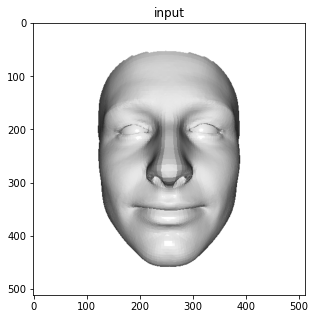

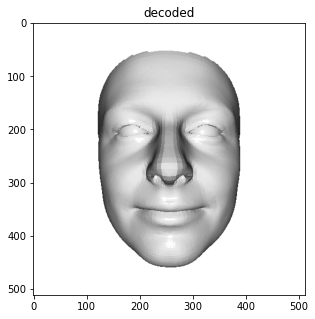

In [17]:

img_index = 1
f_name = img_indices[img_index]

face_shape = np.reshape(np.load(shape_path.format(f_name)), [1, -1])  # [1, 35709 * 3]
face_shape = np.reshape(face_shape, (35709, 3))
part_shape = face_shape[part_vertices]

#face_encoding = torch.from_numpy(np.load(encoding_path.format(f_name))).reshape(1,-1).to(device)

part_shape_pred = vae(torch.from_numpy(part_shape).reshape(1,len(part_vertices),3).to(device))[0].detach().cpu().numpy()


V = np.zeros([35709, 3])
V[part_vertices,:] = part_shape
o3d_mesh, image = render(V, part_Faces)
plt.figure(figsize=(5,5))
plt.title('input')
plt.imshow(np.asarray(image))
plt.show()


V_ = np.zeros([35709, 3])
V_[part_vertices,:] = part_shape_pred
o3d_mesh, image = render(V_, part_Faces)
plt.figure(figsize=(5,5))
plt.title('decoded')
plt.imshow(np.asarray(image))
plt.show()


In [14]:

o3d.visualization.draw_geometries([o3d_mesh])


In [11]:
def plot_reconstructed_2dof(vae, part_vertices, part_faces, r0=(-0.1, 0.1), r1=(-0.1, 0.1), dim_x=0, dim_y=1, n=3):
    w = 512
    img = np.zeros((n*w, n*w, 3))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.zeros([1, 30]).to(device)
            z[0,dim_x] = x
            z[0,dim_y] = y
            x_ = vae.decoder(z)[0].detach().cpu().numpy()
            V = np.zeros([35709, 3])
            V[part_vertices,:] = x_
            o3d_mesh, image = render(V, part_faces)

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = image
    plt.figure(figsize=(10,10))
    plt.imshow(img, extent=[*r0, *r1])
    plt.xlabel('Dimension '+str(dim_x))
    plt.ylabel('Dimension '+str(dim_y))
    plt.show()
    
def plot_reconstructed_1dof(vae, part_vertices, part_faces, r0=(-0.1, 0.1), dim_x=0, n=3):
    w = 512
    img = np.zeros((w, n*w, 3))
    for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.zeros([1, 30]).to(device)
        z[0,dim_x] = x
        x_ = vae.decoder(z)[0].detach().cpu().numpy()
        V = np.zeros([35709, 3])
        V[part_vertices,:] = x_
        o3d_mesh, image = render(V, part_faces)

        img[0:w, j*w:(j+1)*w] = image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()

Dimension 0


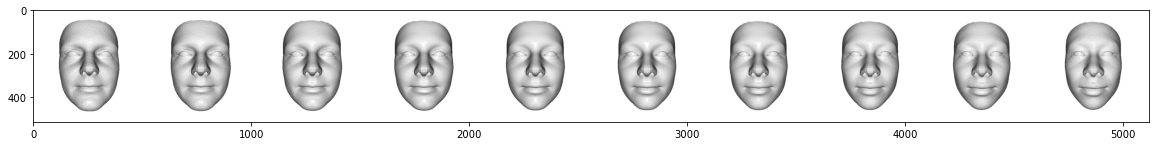

Dimension 1


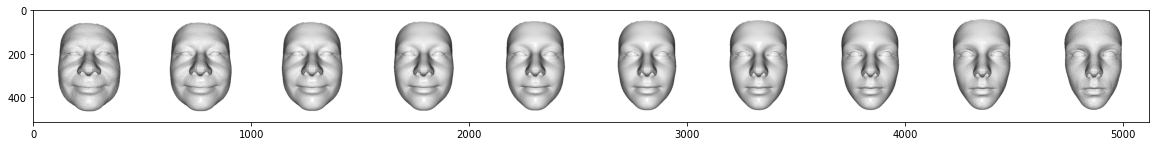

Dimension 2


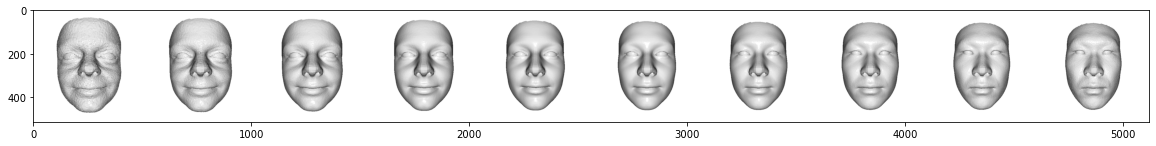

Dimension 3


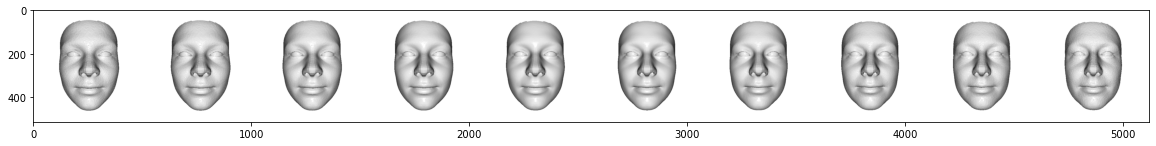

Dimension 4


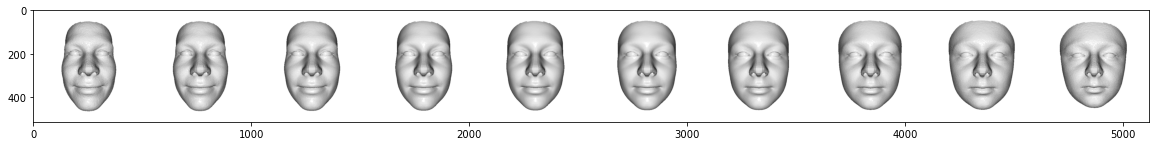

Dimension 5


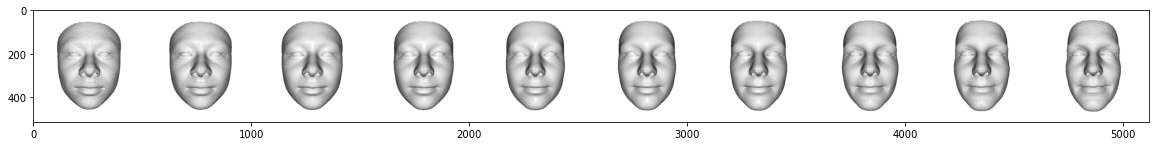

Dimension 6


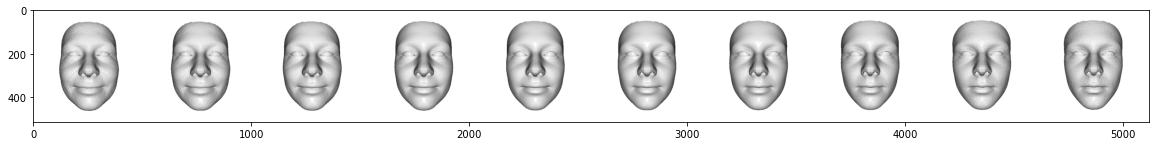

Dimension 7


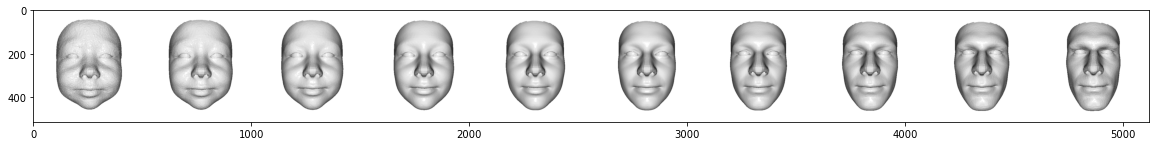

Dimension 8


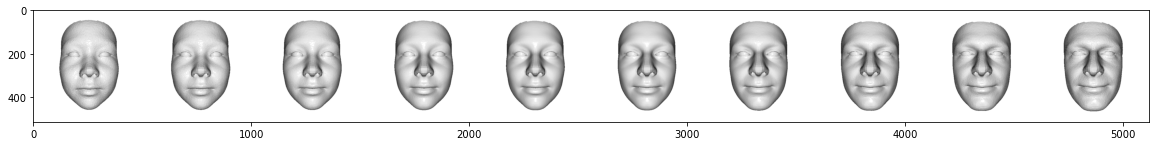

Dimension 9


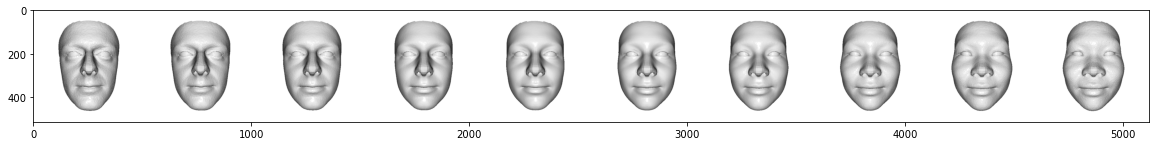

In [12]:

for dimension in range(10):
    print('Dimension', dimension)
    plot_reconstructed_1dof(vae, part_vertices, part_Faces, r0=(-0.05, 0.05), dim_x=dimension, n=10)


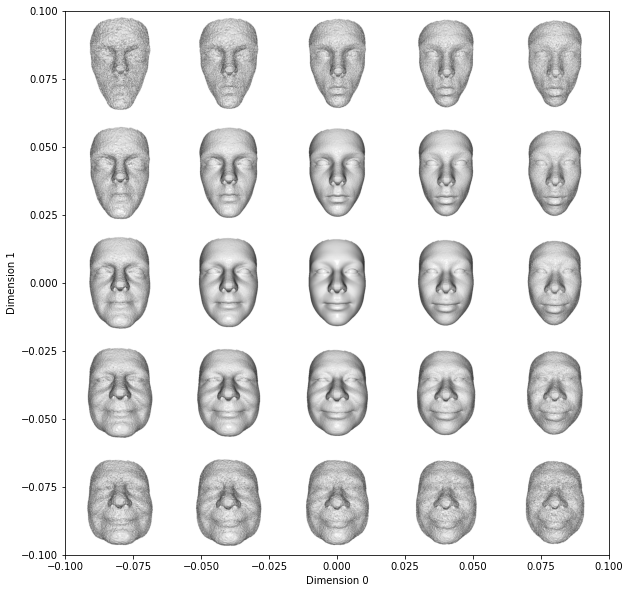

In [88]:
plot_reconstructed_2dof(vae, part_vertices, part_Faces, r0=(-0.1, 0.1), r1=(-0.1, 0.1), dim_x=0, dim_y=1, n=5)
